len(X) =  11982
batchsize =  1024
len(X)%batchsize =  718
Xminbatches[-1] [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.2857142857142857, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14285714285714285, 0.8571428571428571, 0.42857142857142855, 0.2857142857142857, 0.14285714285714285, 0.8571428571428571, 0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14285714285714285, 0.42857142857142855, 0.0, 0.0, 0.0, 0.0, 0.7142857142857143, 0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2857142857142857, 0.5714285714285714, 0.0, 0.0, 0.0, 0.5714285714285714, 0.5714285714285714, 0.0, 0.0, 0.0, 0, 0.0, 0.0, 0.0, 0.0, 0.8571428571428571, 0.0, 0.14285714285714285, 0.7142857142857143, 0.42857142857142855, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.42857142857142855, 0.8571428571428571, 0.8571428571428571, 0.2857142857142857, 0.0, 0.

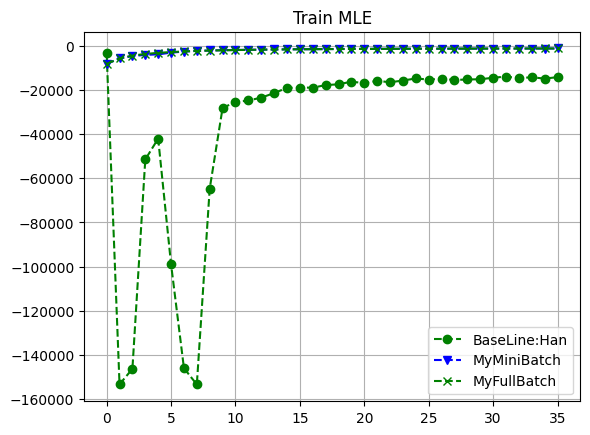

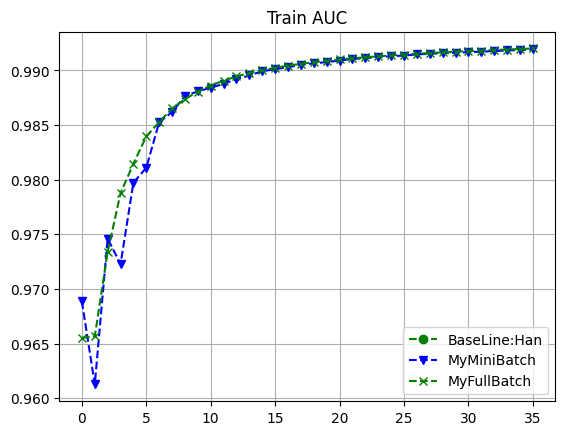

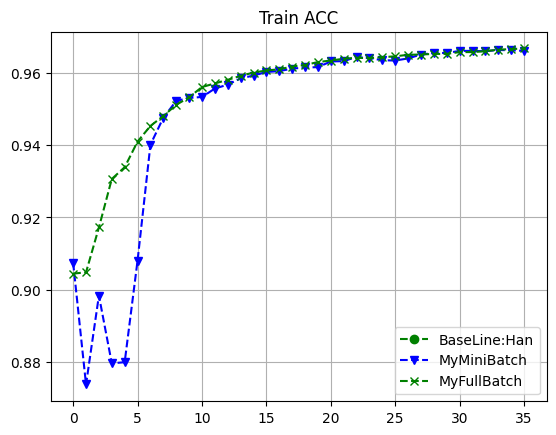

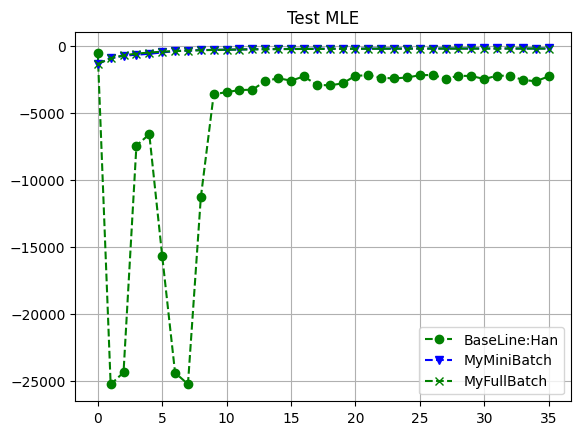

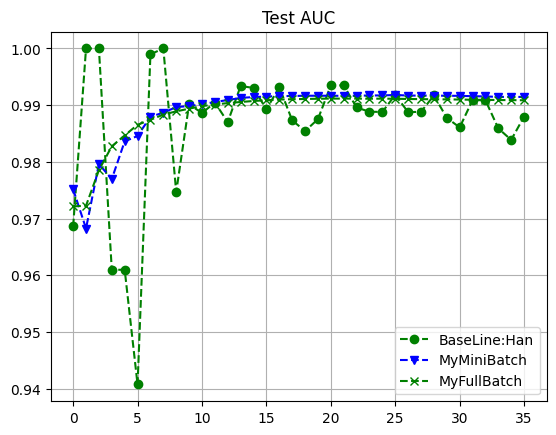

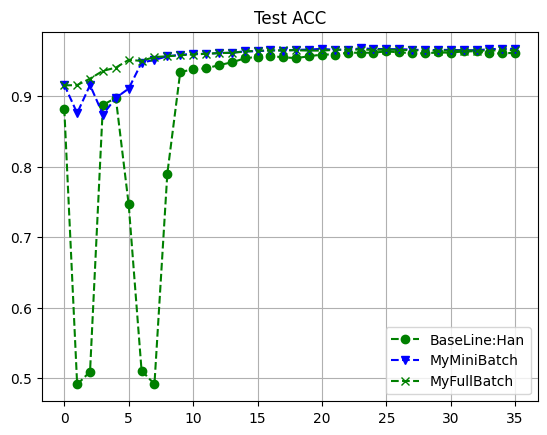

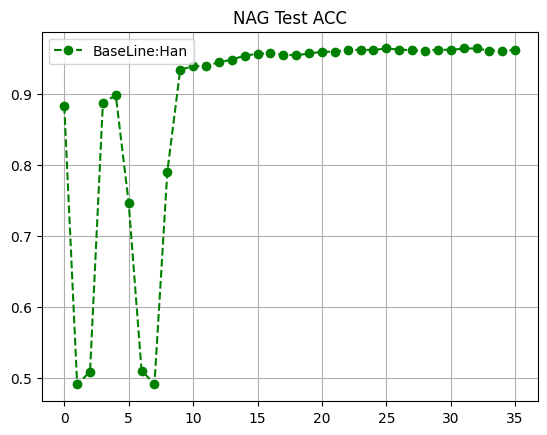

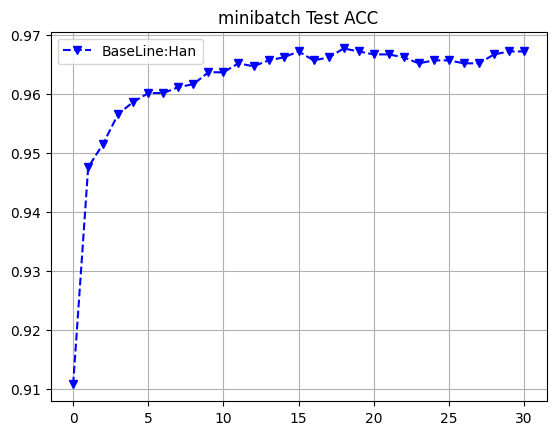

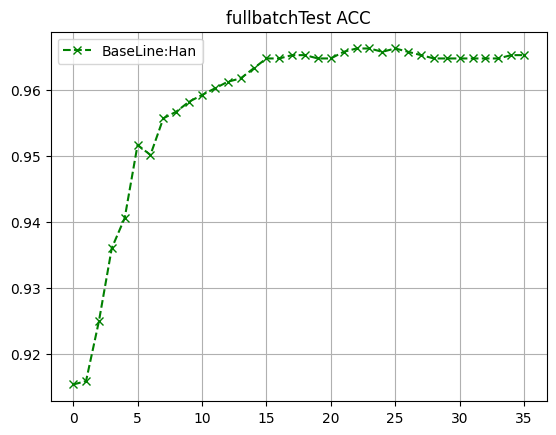

0.9637096774193549 			 25
0.967741935483871 			 23
0.9662298387096774 			 22


In [13]:
# -*- coding: utf-8 -*-
"""20240306_MiniBatchvs.FullBatch_nagwithqg_Credit_using_cycle_learning_rate_python3.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1eiG-n7FJ2nMRnfwjhZTK0RR6DWO4tH6e
"""

# -*- coding: utf-8 -*-
"""20240108 Mini-Batch Version NAGwithQG using Cycle Learning Rate Python3.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1KarHuOmNGhcSLHVhdDhId1B8xKW180XZ
"""

# coding=utf8
# 2019-12-04 09:43 a.m. GMT +08：00
'''
+++++++++++++++++++++++++++++++++++++++++++++++++++++
+       NumPy version 1.10.2    Python 2.7.11       +
+++++++++++++++++++++++++++++++++++++++++++++++++++++
'''
import os
import math
import time
import random
import sys

import csv

from copy import deepcopy
from math import log, exp, pow, sqrt

import matplotlib
#matplotlib.use('pdf')
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True)


epsilon = 1e-10
# The ROC curve is constructed by plotting the (X=FPR, Y=TPR) pairs for each possible value
# of the threshold. By computing the TPR and FPR for varying thresholds in [0,1], we can construct
# the receiver operating characteristic curve or ROC-curve.
#     +--------------------------------------- actual class --------------------------+
#     +-----------------------              -1               +1 ----------------------+
#     +------------- predicted  -1   true negative (TN) false negative (FN) ----------+
#     +-------------     class  +1   false positive(FP) true positive (TP)  ----------+
#     +-------------------------------------------------------------------------------+
#     +------------- X = FPR = #FP/(#FP + #TN) ---- Y = TPR = #TP/(#TP + #FN) --------+
#     +-------------------------------------------------------------------------------+
#            X:实际负类中预测结果(正类)出错的比例       Y:实际正类中预测结果(正类)的比例
# -----------------------------------------------------------------------------------------
# Calculate the ROC-curve and the value of AUC
# INPUT: score = [0.9, 0.8, 0.7, 0.6, 0.55, 0.54, 0.53, 0.52, 0.51, 0.505, 0.4, ... ]
#        y = [1,1,0, 1, 1, 1, 0, 0, 1, 0, 1,0, 1, 0, 0, 0, 1 , 0, 1, 0]
# WARNNING: WHAT ARE THE LABELS ? {-0, +1} or {-1, +1}
def ROCAUC(score, y, show=False):
	z = list(zip(score, y))
	z.sort()
	score = [ x[0] for x in z ]
	y = [ x[1] for x in z ]

	# score is already in order
	thr = score

	POSITIVE = y.count(+1)
	NEGATIVE = y.count(-1)            # WARNNING: WHAT ARE THE LABELS ?
	roc_x = [1]
	roc_y = [1]
	FN = 0
	TN = 0
	# need (score,y) to be sorted
	for (i, T) in enumerate(thr):
		if y[i]==+1:
			FN = FN + 1
		if y[i]==-1:                  # WARNNING: WHAT ARE THE LABELS ?
			TN = TN + 1
		roc_x.append(1-TN/float(NEGATIVE))
		roc_y.append(1-FN/float(POSITIVE))
	z = list(zip(roc_x, roc_y))
	z.sort()
	roc_x = [ x[0] for x in z ]
	roc_y = [ x[1] for x in z ]
	#print zip(roc_x,roc_y)

	AUC = 0.0
	prex = roc_x[0]
	for (i, x) in enumerate(roc_x):
		AUC += (x-prex)*roc_y[i]
		prex = x
	#print AUC

	if show:
		plt.plot(roc_x, roc_y)
		plt.plot([0,1],[0,1])
		plt.axis("equal")
		plt.title('AUC = '+str(AUC))
		plt.grid(color='b' , linewidth='0.3' ,linestyle='--')
		plt.show()
	return AUC

def ACC(score, y, show=False):
	POSITIVE = y.count(+1)
	NEGATIVE = y.count(-1)            # WARNNING: WHAT ARE THE LABELS ?

	TP = 0
	TN = 0
	# need (score,y) to be sorted
	for (i, s) in enumerate(score):
		if y[i]==+1 and s>=0.5:
			TP = TP + 1
		if y[i]==-1 and s <0.5:                  # WARNNING: WHAT ARE THE LABELS ?
			TN = TN + 1

	#print 'TP = ',TP, ', TN = ',TN,
	ACC = float(TN + TP)/len(y)
	return ACC

# used for the input range of sigmoid
def limit(inputx):
	#return inputx
	if inputx > 125 :
		return 25
	if inputx < -125 :
		return -25;
	return inputx


class MonotonicExponentialLR:
    def __init__(self, max_lr, min_lr, total_steps, gamma, last_epoch=-1):
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.total_steps = total_steps
        self.gamma = gamma
        self.current_step = 0
        self.last_epoch = last_epoch

    def step(self):
        if self.last_epoch > self.total_steps:
            lr = self.min_lr
        else:
            lr = self.min_lr + (self.max_lr - self.min_lr) * math.exp(- self.current_step / self.total_steps / self.gamma)
            self.current_step += 1
            lr = max(lr, self.min_lr)
        return lr



# Stage 1.
#     Step 1. Extract test data from a csv file
with open('MNIST_test.txt','r') as csvfile:
#with open('Credit_test.csv','r') as csvfile:
	reader = csv.reader(csvfile)
	next(reader)  # Skip the first row # leave behind the first row
	testdata = []
	for row in reader:
		# reader.next() return a string
		row = [float(x) for x in row]
		testdata.append(row)
csvfile.close()
#     Step 4. Extract testX and testY from testdata
testX = [[1]+row[1:] for row in testdata[:]]
for colidx in range(len(testX[0])):
	colmax = testX[0][colidx]
	colmin = testX[0][colidx]
	for (rowidx, row) in enumerate(testX):
		if row[colidx] >= colmax :
			colmax = row[colidx]
		if row[colidx] <= colmin :
			colmin = row[colidx]
	for (rowidx, row) in enumerate(testX):
		if (colmax - colmin) < epsilon:
			if colmin <= 0:
				row[colidx] = 0
			if colmax >= 1:
				row[colidx] = 1
		else:
			row[colidx] = float(row[colidx] - colmin) / (colmax - colmin)
testY = [int(row[0]) for row in testdata[:]]
# turn y{+0,+1} to y{-1,+1}
testY = [2*y-1 for y in testY]    # DONT FORGET THAT THE IDASH DATASET IS DIFFERENT FROM THE MNIST DATASET!

#     Step 1. Extract train data from a csv file
with open('MNIST_train.txt','r') as csvfile:
#with open('Credit_train.csv','r') as csvfile:
	reader = csv.reader(csvfile)
	next(reader)  # Skip the first row# leave behind the first row
	data = []
	for row in reader:
		# reader.next() return a string
		row = [float(x) for x in row]
		data.append(row)
csvfile.close()
#     Step 2. Extract X and Y from data
X = [[1]+row[1:] for row in data[:]]
for colidx in range(len(X[0])):
	colmax = X[0][colidx]
	colmin = X[0][colidx]
	for (rowidx, row) in enumerate(X):
		if row[colidx] >= colmax :
			colmax = row[colidx]
		if row[colidx] <= colmin :
			colmin = row[colidx]
	for (rowidx, row) in enumerate(X):
		if (colmax - colmin) < epsilon:
			if colmin <= 0:
				row[colidx] = 0
			if colmax >= 1:
				row[colidx] = 1
		else:
			row[colidx] = float(row[colidx] - colmin) / (colmax - colmin)
Y = [int(row[0]) for row in data[:]]
# turn y{+0,+1} to y{-1,+1}
Y = [2*y-1 for y in Y]    # DONT FORGET THAT THE IDASH DATASET IS DIFFERENT FROM THE MNIST DATASET!
MX = np.matrix(X)
MY = np.matrix(Y)


allMB_inv = np.matrix(np.eye(MX.shape[1]))
for idx in range(MX.shape[1]):
	allMB_inv[idx,idx] = 1.0 / ( (+.25)*MX.T.dot( MX.sum(axis=1) )[idx, 0]  + epsilon )

#should shuffle [Y,X] together in the Iteration Processes!
'''
Z = zip(Y,X)
random.shuffle(Z)
#should shuffle [Y,X] together!
X = [item[1] for item in Z]
Y = [item[0] for item in Z]
'''

#batchsize = 32  #   32   64   128   256   512   1024
#batchsize = 64  #   32   64   128   256   512   1024
#batchsize = 128  #   32   64   128   256   512   1024
#batchsize = 256  #   32   64   128   256   512   1024
#batchsize = 512  #   32   64   128   256   512   1024
batchsize = 1024  #   32   64   128   256   512   1024


Xminbatches = []
idx=0
while True:
	if idx+batchsize > len(X): break
	batch=[]
	for i in range(idx,idx+batchsize):
		batch.append(X[i])
	Xminbatches.append(batch)
	idx += batchsize
if len(X)%batchsize != 0:
	batch=[]
	for i in range(idx, len(X)):
		batch.append(X[i])
	Xminbatches.append(batch)
print('len(X) = ', len(X))
print('batchsize = ', batchsize)
print('len(X)%batchsize = ', len(X) % batchsize)
print('Xminbatches[-1]', Xminbatches[-1])
#print 'Xminbatches'
Yminbatches = []
idx=0
while True:
	if idx+batchsize > len(Y): break
	batch=[]
	for i in range(idx,idx+batchsize):
		batch.append(Y[i])
	Yminbatches.append(batch)
	idx += batchsize
if len(Y)%batchsize != 0:
	batch=[]
	for i in range(idx, len(Y)):
		batch.append(Y[i])
	Yminbatches.append(batch)
#print 'Yminbatches[0]', Yminbatches[0]
#print 'Yminbatches[-1]', Yminbatches[-1]
print('len(Yminbatches[-1]) = ', len(Yminbatches[-1]))








hlambda = lambda x:1.0/(1+exp(-x))
##y = 0.5  +  0.15012 x^1  -  0.0015930078125 x^3 (0.001593008)
#hlambda = lambda x:5.0000e-01  +0.15012*x  -  0.0015930078125*pow(x,3)
#hlambda = lambda x:5.0000e-01  +0.0843*x  -  0.0002*pow(x,3)
#hlambda = lambda x:5.0000e-01  +0.057485*x  -  0.000076416*pow(x,3)
#static double degree3[4] = {0.5,-0.15012,0.0,0.001593}; //> ~ 1 / (1 + exp(x)) (LSFitting with bnd [-8,8])
#static double degree3[4] = {0.5,-0.0843,0.0,0.0002}; //> ~ 1/ (1 + exp(x)) (LSFitting with bnd [-16,16])
#static double degree3[3] = {0.5,  -0.057485,      0.000076416}; //> ~ 1/ (1 + exp(x)) polyfit [-24:0.01:+24]

Epoch_Number = 3

#   scheduler = MonotonicExponentialLR(max_lr, min_lr, total_steps, gamma)
#   learning rate = max_lr * (max_lr / min_lr) ** ( -current_step / (total_steps * gamma) )
# A : initial_learning_rate
# iterations : current_iteration


#baselineHanLR = 0.01 # for Financial (Credit dataset)
#min_lr = 1.0
#total_steps = Epoch_Number * len(Xminbatches)
#gamma=    0.9
#max_lr=2.0    #最佳0.800533689126084 			 74
#DataSet = 'Credit' +'_CLR[' + str(min_lr) + '-' + str(max_lr) + ']'


baselineHanLR = 1.00 # for MNIST dataset
min_lr = 1.0
total_steps = Epoch_Number * len(Xminbatches)
gamma=    0.9
max_lr=3.0   #最佳 0.9662298387096774 			 19-th      #max_lr=3.2
DataSet = 'MNIST' +'_CLR[' + str(min_lr) + '-' + str(max_lr) + ']'



RandomList = []
for en in range(Epoch_Number):
	for it in range(len(Xminbatches)):
		RandomList.append(it)
		#RandomList.append(random.randint(0, len(Xminbatches)-1 ))

'''
-------------------------------------------------------------------------------------------
---------------------  NAG for min-batch with Han's Learning-Rate Setting -----------------
-------------------------------------------------------------------------------------------
------------------------------ Nesterov Accelerated Gradient ------------------------------
-------------------------------------------------------------------------------------------
'''
# Stage 2.
#     Step 1. Initialize Simplified Fixed Hessian Matrix For each min-batch
MX = np.matrix(X)

# return a column vector whose each element is the sum of each row of MX
mx = MX.sum(axis=1)
# return a column vector whose each element is the sum of each row of (X.T * X)
mxtmx = MX.T.dot(mx)


#     Step 2. Initialize Weight Vector (n x 1)
# Setting the initial weight to 1 leads to a large input to sigmoid function,
# which would cause a big problem to this algorithm when using polynomial
# to substitute the sigmoid function. So, it is a good choice to set w = 0.

# [[0]... to make MW a column vector(matrix)
V = [[0.0] for x in range(mxtmx.shape[0])]
W = [[0.0] for x in range(mxtmx.shape[0])]
MV = np.matrix(V)
MW = np.matrix(W)

#     Step 2. Set the Maximum Iteration and Record each cost function
NAG_testMLE = []
NAG_testAUC = []
NAG_testACC = []
NAG_trainMLE = []
NAG_trainAUC = []
NAG_trainACC = []

alpha0 = 0.01
alpha1 = (1. + sqrt(1. + 4.0 * alpha0 * alpha0)) / 2.0

# Stage 3.
#     Start the Gradient Descent algorithm
#     Note: h(x) = Prob(y=+1|x) = 1/(1+exp(-W.T*x))
#           1-h(x)=Prob(y=-1|x) = 1/(1+exp(+W.T*x))
#                  Prob(y= I|x) = 1/(1+exp(-I*W.T*x))
#           grad = [Y@(1 - sigm(yWTx))]T * X
for en in range(Epoch_Number):
	for it in range(len(Xminbatches)):
		#print(en + 1, '-th epoch :: ', end="")


		batchidx = RandomList[en * len(Xminbatches) + it]
		#Xbatch = Xminbatches[batchidx]
		Xbatch = Xminbatches[it]


		eta = (1 - alpha0) / alpha1


		#gamma = 1.0/len(Xbatch)/(1 + en*len(Xminbatches) + it)
		gamma = baselineHanLR#/len(Xbatch)
		#gamma = 1.0/(1 + iter + i)/len(Xminbatches[0])
		#gamma = 1.0/(1 + iter*batchsize + i)

		#Ybatch = Yminbatches[batchidx]
		Ybatch = Yminbatches[it]
		#     Step 1. Calculate the Gradient = [Y@(1 - sigm(Y@WT*X))]T * X
		# W.T * X
		MXbatch = np.matrix(Xbatch)
		MXbatchV = MXbatch * MV
		# [Y@(1 - sigm(Y@WT*X))]     (Y=1 if h(x)>.5)
		yhypothesis = []
		#print("\nThe Inputs to 1-Sigmoid of the ", it, "-th batch:")
		for idx in range(len(Ybatch)):

			# hlambda(): the polynomial function to substitute the Sigmoid function
			h = 1 - hlambda(limit(Ybatch[idx]*MXbatchV.A[idx][0]));#print("{:.6f}".format(h), end="\t")


			yhypothesis.append([h*Ybatch[idx]])

		Myhypothesis = np.matrix(yhypothesis)
		Mg = MXbatch.T * Myhypothesis
		#if it != 12: continue
		#print(Xbatch)
		#sys.exit("程序提前结束")


		# return a column vector whose each element is the sum of each row of MX
		mx = MXbatch.sum(axis=1)
		mxtmx = MXbatch.T.dot(mx)
		MB_inv = np.matrix(np.eye(mxtmx.shape[0]))
		for idx in range(mxtmx.shape[0]):
			MB_inv[idx,idx] = 1.0 / ( (+.25)*mxtmx[idx, 0]  + epsilon )

		#MG = MB_inv * Mg
		# should be 'plus', 'cause to compute the MLE
		#MtmpW = MV + (1.0 + gamma) * MG
		MtmpW = MV + gamma * Mg
		MV = (1.0-eta)*MtmpW + (eta)*MW
		MW = MtmpW


	#     Step 4. Calculate the cost function using Maximum likelihood Estimation
		# log-likelihood
		newMtrainXV = MX * MV
		loghx = []
		for idx in range(len(Y)):
			# WARNING: iff y in {-1,+1}
			loghxi = -log(1+exp(limit(-Y[idx]*newMtrainXV.A[idx][0])))
			loghx.append(loghxi)
		loglikelihood = sum(loghx)
		NAG_trainMLE.append(loglikelihood)

		MtestX = np.matrix(testX)
		newMtestXV = MtestX * MV
		loghx = []
		for idx in range(len(testY)):
			# WARNING: iff y in {-1,+1}
			loghxi = -log(1+exp(limit(-testY[idx]*newMtestXV.A[idx][0])))
			loghx.append(loghxi)
		loglikelihood = sum(loghx)
		NAG_testMLE.append(loglikelihood)


		# BE CAREFULL WITH INPUT LABELS!
		newhypothesis = []
		for idx in range(len(testY)):
			hx = 1.0/(1+exp(limit(-newMtestXV.A[idx][0])))
			newhypothesis.append(hx)
		hxlist = [ hx for hx in newhypothesis ]
		print('Han ', it, '-th AUC : ', ROCAUC(hxlist, testY), ' MLE = ', loglikelihood, ' ACC = ', ACC(hxlist, testY))
		NAG_testAUC.append(ROCAUC(hxlist, testY))
		NAG_testACC.append(ACC(hxlist, testY))

		alpha0 = alpha1
		alpha1 = (1. + sqrt(1. + 4.0 * alpha0 * alpha0)) / 2.0


'''
-------------------------------------------------------------------------------------------
----------------------------------- end of experiments -----------------------------------
-------------------------------------------------------------------------------------------
'''


'''
-------------------------------------------------------------------------------------------
---------------  Enhanced NAG for mini-batch with MonotonicExponentialLR Setting  ---------------
-------------------------------------------------------------------------------------------
'''
# Stage 2.
#     Step 1. Initialize Simplified Fixed Hessian Matrix For each min-batch
MX = np.matrix(X)

# return a column vector whose each element is the sum of each row of MX
mx = MX.sum(axis=1)
# return a column vector whose each element is the sum of each row of (X.T * X)
mxtmx = MX.T.dot(mx)


#     Step 2. Initialize Weight Vector (n x 1)
# [[0]... to make MW a column vector(matrix)
V = [[0.0] for x in range(mxtmx.shape[0])]
W = [[0.0] for x in range(mxtmx.shape[0])]
MV = np.matrix(V)
MW = np.matrix(W)

#     Step 2. Set the Maximum Iteration and Record each cost function
NAGQG_minibatch_testMLE = []
NAGQG_minibatch_testAUC = []
NAGQG_minibatch_testACC = []
NAGQG_minibatch_trainMLE = []
NAGQG_minibatch_trainAUC = []
NAGQG_minibatch_trainACC = []

alpha0 = 0.01
alpha1 = (1. + sqrt(1. + 4.0 * alpha0 * alpha0)) / 2.0

melr = MonotonicExponentialLR(max_lr, min_lr, total_steps, gamma)
for en in range(Epoch_Number):
	for it in range(len(Xminbatches)):
		#print(en + 1, '-th epoch :: ', end="")


		batchidx = RandomList[en * len(Xminbatches) + it]
		#Xbatch = Xminbatches[batchidx]
		Xbatch = Xminbatches[it]


		eta = (1 - alpha0) / alpha1

		lr = melr.step();


		#Ybatch = Yminbatches[batchidx]
		Ybatch = Yminbatches[it]
		#     Step 1. Calculate the Gradient = [Y@(1 - sigm(Y@WT*X))]T * X
		# W.T * X
		MXbatch = np.matrix(Xbatch)
		MXbatchV = MXbatch * MV
		# [Y@(1 - sigm(Y@WT*X))]     (Y=1 if h(x)>.5)
		yhypothesis = []
		#print("\nThe Inputs to 1-Sigmoid of the ", it, "-th batch:")
		for idx in range(len(Ybatch)):

			# hlambda(): the polynomial function to substitute the Sigmoid function
			h = 1 - hlambda(limit(Ybatch[idx]*MXbatchV.A[idx][0]));#print("{:.6f}".format(h), end="\t")


			yhypothesis.append([h*Ybatch[idx]])

		Myhypothesis = np.matrix(yhypothesis)
		Mg = MXbatch.T * Myhypothesis
		#if it != 12: continue
		#print(Xbatch)
		#sys.exit("程序提前结束")


		# return a column vector whose each element is the sum of each row of MX
		mx = MXbatch.sum(axis=1)
		mxtmx = MXbatch.T.dot(mx)
		MB_inv = np.matrix(np.eye(mxtmx.shape[0]))
		for idx in range(mxtmx.shape[0]):
			MB_inv[idx,idx] = 1.0 / ( (+.25)*mxtmx[idx, 0]  + epsilon )


		MG = MB_inv * Mg;
		# should be 'plus', 'cause to compute the MLE
		MtmpW = MV + lr * MG
		#MtmpW = MV + lr * MG
		MV = (1.0-eta)*MtmpW + (eta)*MW
		MW = MtmpW;


	#     Step 4. Calculate the cost function using Maximum likelihood Estimation
		# log-likelihood
		newMtrainXV = MX * MV
		loghx = []
		for idx in range(len(Y)):
			# WARNING: iff y in {-1,+1}
			loghxi = -log(1+exp(limit(-Y[idx]*newMtrainXV.A[idx][0])))
			loghx.append(loghxi)
		loglikelihood = sum(loghx)
		NAGQG_minibatch_trainMLE.append(loglikelihood)

		newhypothesis = []
		for idx in range(len(Y)):
			hx = 1.0/(1+exp(limit(-newMtrainXV.A[idx][0])))
			newhypothesis.append(hx)
		hxlist = [ hx for hx in newhypothesis ]
		#print('step_size=', step_size, ' ', it, '-th AUC : ', ROCAUC(hxlist, Y), ' MLE = ', loglikelihood, ' ACC = ', ACC(hxlist, Y))
		NAGQG_minibatch_trainAUC.append(ROCAUC(hxlist, Y))
		NAGQG_minibatch_trainACC.append(ACC(hxlist, Y))



		MtestX = np.matrix(testX)
		newMtestXV = MtestX * MV
		loghx = []
		for idx in range(len(testY)):
			# WARNING: iff y in {-1,+1}
			loghxi = -log(1+exp(limit(-testY[idx]*newMtestXV.A[idx][0])))
			loghx.append(loghxi)
		loglikelihood = sum(loghx)
		NAGQG_minibatch_testMLE.append(loglikelihood)


		# BE CAREFULL WITH INPUT LABELS!
		newhypothesis = []
		for idx in range(len(testY)):
			hx = 1.0/(1+exp(limit(-newMtestXV.A[idx][0])))
			newhypothesis.append(hx)
		hxlist = [ hx for hx in newhypothesis ]
		print('Mini-Batch ', it, '-th AUC : ', ROCAUC(hxlist, testY), ' MLE = ', loglikelihood, ' ACC = ', ACC(hxlist, testY))
		NAGQG_minibatch_testAUC.append(ROCAUC(hxlist, testY))
		NAGQG_minibatch_testACC.append(ACC(hxlist, testY));#print("MV :\n",MV);#sys.exit("程序提前结束")

		alpha0 = alpha1
		alpha1 = (1. + sqrt(1. + 4.0 * alpha0 * alpha0)) / 2.0; #print("The Weight: ", MV)
	#sys.exit("程序提前结束")

'''
-------------------------------------------------------------------------------------------
---------------  Enhanced NAG for full-batch with CLR Setting: step_size=2.  ---------------
-------------------------------------------------------------------------------------------
'''
# Stage 2.
#     Step 1. Initialize Simplified Fixed Hessian Matrix For each min-batch
MX = np.matrix(X)

# return a column vector whose each element is the sum of each row of MX
mx = MX.sum(axis=1)
# return a column vector whose each element is the sum of each row of (X.T * X)
mxtmx = MX.T.dot(mx)


#     Step 2. Initialize Weight Vector (n x 1)
# [[0]... to make MW a column vector(matrix)
V = [[0.0] for x in range(mxtmx.shape[0])]
W = [[0.0] for x in range(mxtmx.shape[0])]
MV = np.matrix(V)
MW = np.matrix(W)

#     Step 2. Set the Maximum Iteration and Record each cost function
NAGQG_fullbatch_testMLE = []
NAGQG_fullbatch_testAUC = []
NAGQG_fullbatch_testACC = []
NAGQG_fullbatch_trainMLE = []
NAGQG_fullbatch_trainAUC = []
NAGQG_fullbatch_trainACC = []

alpha0 = 0.01
alpha1 = (1. + sqrt(1. + 4.0 * alpha0 * alpha0)) / 2.0

melr = MonotonicExponentialLR(max_lr, min_lr, total_steps, gamma)
for en in range(Epoch_Number):
	for it in range(len(Xminbatches)):
		print(en + 1, '-th iter :: ', end="")

		#batchidx = RandomList[en * len(Xminbatches) + it]
		Xbatch = np.matrix(X)


		eta = (1 - alpha0) / alpha1

		lr = melr.step()


		Ybatch = Y
		#     Step 1. Calculate the Gradient = [Y@(1 - sigm(Y@WT*X))]T * X
		# W.T * X
		MXbatch = np.matrix(Xbatch)
		MXbatchV = MXbatch * MV
		# [Y@(1 - sigm(Y@WT*X))]     (Y=1 if h(x)>.5)
		yhypothesis = []
		for idx in range(len(Ybatch)):

			# hlambda(): the polynomial function to substitute the Sigmoid function
			h = 1 - hlambda(limit(Ybatch[idx]*MXbatchV.A[idx][0]))

			yhypothesis.append([h*Ybatch[idx]])

		Myhypothesis = np.matrix(yhypothesis)
		Mg = MXbatch.T * Myhypothesis


		# return a column vector whose each element is the sum of each row of MX
		mx = MXbatch.sum(axis=1)
		mxtmx = MXbatch.T.dot(mx)
		MB_inv = np.matrix(np.eye(mxtmx.shape[0]))
		for idx in range(mxtmx.shape[0]):
			MB_inv[idx,idx] = 1.0 / ( (+.25)*mxtmx[idx, 0]  + epsilon )


		MG = allMB_inv * Mg
		# should be 'plus', 'cause to compute the MLE
		MtmpW = MV + lr * MG
		#MtmpW = MV + lr * MG
		MV = (1.0-eta)*MtmpW + (eta)*MW
		MW = MtmpW


	#     Step 4. Calculate the cost function using Maximum likelihood Estimation
		# log-likelihood
		newMtrainXV = MX * MV
		loghx = []
		for idx in range(len(Y)):
			# WARNING: iff y in {-1,+1}
			loghxi = -log(1+exp(limit(-Y[idx]*newMtrainXV.A[idx][0])))
			loghx.append(loghxi)
		loglikelihood = sum(loghx)
		NAGQG_fullbatch_trainMLE.append(loglikelihood)

		newhypothesis = []
		for idx in range(len(Y)):
			hx = 1.0/(1+exp(limit(-newMtrainXV.A[idx][0])))
			newhypothesis.append(hx)
		hxlist = [ hx for hx in newhypothesis ]
		#print('step_size=', step_size, ' ', it, '-th AUC : ', ROCAUC(hxlist, Y), ' MLE = ', loglikelihood, ' ACC = ', ACC(hxlist, Y))
		NAGQG_fullbatch_trainAUC.append(ROCAUC(hxlist, Y))
		NAGQG_fullbatch_trainACC.append(ACC(hxlist, Y))


		MtestX = np.matrix(testX)
		newMtestXV = MtestX * MV
		loghx = []
		for idx in range(len(testY)):
			# WARNING: iff y in {-1,+1}
			loghxi = -log(1+exp(limit(-testY[idx]*newMtestXV.A[idx][0])))
			loghx.append(loghxi)
		loglikelihood = sum(loghx)
		NAGQG_fullbatch_testMLE.append(loglikelihood)


		# BE CAREFULL WITH INPUT LABELS!
		newhypothesis = []
		for idx in range(len(testY)):
			hx = 1.0/(1+exp(limit(-newMtestXV.A[idx][0])))
			newhypothesis.append(hx)
		hxlist = [ hx for hx in newhypothesis ]
		print('Full-Batch ', it, '-th AUC : ', ROCAUC(hxlist, testY), ' MLE = ', loglikelihood, ' ACC = ', ACC(hxlist, testY))
		NAGQG_fullbatch_testAUC.append(ROCAUC(hxlist, testY))
		NAGQG_fullbatch_testACC.append(ACC(hxlist, testY))

		alpha0 = alpha1
		alpha1 = (1. + sqrt(1. + 4.0 * alpha0 * alpha0)) / 2.0






label = [ 'BaseLine:Han', 'MyMiniBatch', 'MyFullBatch']
plt.plot(range(len(NAG_trainMLE)), NAG_trainMLE, 'o--g')
plt.plot(range(len(NAGQG_minibatch_trainMLE)), NAGQG_minibatch_trainMLE, 'v--b')
plt.plot(range(len(NAGQG_fullbatch_trainMLE)), NAGQG_fullbatch_trainMLE, 'x--g')
#plt.axis("equal")
plt.title('Train MLE')
plt.legend(label, loc = 0, ncol = 1)
plt.grid()
plt.show()
plt.savefig(DataSet   + '_gamma=' + str(gamma) + 'batchsize=' + str(batchsize) + 'epochnumbe=' + str(Epoch_Number) +"TrainMLE.png")
#plt.close()
# -- Iterations -- stepsize1 -- stepsize2 -- ...
filePath = DataSet   + '_gamma=' + str(gamma) + 'batchsize=' + str(batchsize) + 'epochnumbe=' + str(Epoch_Number)  +"TrainMLE.csv"
PythonExperiment =      open(filePath,      'w')
PythonExperiment =      open(filePath,      'a+b')
PythonExperiment.write('Iterations'.encode('utf-8'));
PythonExperiment.write(','.encode('utf-8'));
PythonExperiment.write('stepsize1'.encode('utf-8'));
PythonExperiment.write(','.encode('utf-8'));
PythonExperiment.write('stepsize2'.encode('utf-8'));
PythonExperiment.write("\n".encode('utf-8'));
for (idx, ele) in enumerate(NAGQG_minibatch_trainMLE):
	PythonExperiment.write(str(idx).encode('utf-8'));
	PythonExperiment.write(','.encode('utf-8'));
	PythonExperiment.write(str(NAGQG_minibatch_trainMLE[idx]).encode('utf-8'));
	PythonExperiment.write(','.encode('utf-8'));
	PythonExperiment.write(str(NAGQG_fullbatch_trainMLE[idx]).encode('utf-8'));
	PythonExperiment.write("\n".encode('utf-8'));
PythonExperiment.close();


plt.plot(range(len(NAG_trainAUC)), NAG_trainAUC, 'o--g')
plt.plot(range(len(NAGQG_minibatch_trainAUC)), NAGQG_minibatch_trainAUC, 'v--b')
plt.plot(range(len(NAGQG_fullbatch_trainAUC)), NAGQG_fullbatch_trainAUC, 'x--g')
#plt.axis("equal")
plt.title('Train AUC')
plt.legend(label, loc = 0, ncol = 1)
plt.grid()
plt.show()
plt.savefig(DataSet   + '_gamma=' + str(gamma) + 'batchsize=' + str(batchsize) + 'epochnumbe=' + str(Epoch_Number) +"TrainAUC.png")
#plt.close()
# -- Iterations -- stepsize1 -- stepsize2 -- ...
filePath = DataSet   + '_gamma=' + str(gamma) + 'batchsize=' + str(batchsize) + 'epochnumbe=' + str(Epoch_Number)  +"TrainAUC.csv";
PythonExperiment =      open(filePath,      'w')
PythonExperiment =      open(filePath,      'a+b')
PythonExperiment.write('Iterations'.encode('utf-8'));
PythonExperiment.write(','.encode('utf-8'));
PythonExperiment.write('stepsize1'.encode('utf-8'));
PythonExperiment.write(','.encode('utf-8'));
PythonExperiment.write('stepsize2'.encode('utf-8'));
PythonExperiment.write("\n".encode('utf-8'));
for (idx, ele) in enumerate(NAGQG_minibatch_trainAUC):
	PythonExperiment.write(str(idx).encode('utf-8'));
	PythonExperiment.write(','.encode('utf-8'));
	PythonExperiment.write(str(NAGQG_minibatch_trainAUC[idx]).encode('utf-8'));
	PythonExperiment.write(','.encode('utf-8'));
	PythonExperiment.write(str(NAGQG_fullbatch_trainAUC[idx]).encode('utf-8'));
	PythonExperiment.write("\n".encode('utf-8'));
PythonExperiment.close();


plt.plot(range(len(NAG_trainACC)), NAG_trainACC, 'o--g')
plt.plot(range(len(NAGQG_minibatch_trainACC)), NAGQG_minibatch_trainACC, 'v--b')
plt.plot(range(len(NAGQG_fullbatch_trainACC)), NAGQG_fullbatch_trainACC, 'x--g')
#plt.axis("equal")
plt.title('Train ACC')
plt.legend(label, loc = 0, ncol = 1)
plt.grid()
plt.show()
plt.savefig(DataSet   + '_gamma=' + str(gamma) + 'batchsize=' + str(batchsize) + 'epochnumbe=' + str(Epoch_Number) +"TrainACC.png")
#plt.close()
# -- Iterations -- stepsize1 -- stepsize2 -- ...
filePath = DataSet   + '_gamma=' + str(gamma) + 'batchsize=' + str(batchsize) + 'epochnumbe=' + str(Epoch_Number)  +"TrainACC.csv";
PythonExperiment =      open(filePath,      'w')
PythonExperiment =      open(filePath,      'a+b')
PythonExperiment.write('Iterations'.encode('utf-8'));
PythonExperiment.write(','.encode('utf-8'));
PythonExperiment.write('stepsize1'.encode('utf-8'));
PythonExperiment.write(','.encode('utf-8'));
PythonExperiment.write('stepsize2'.encode('utf-8'));
PythonExperiment.write("\n".encode('utf-8'));
for (idx, ele) in enumerate(NAGQG_minibatch_trainACC):
	PythonExperiment.write(str(idx).encode('utf-8'));
	PythonExperiment.write(','.encode('utf-8'));
	PythonExperiment.write(str(NAGQG_minibatch_trainACC[idx]).encode('utf-8'));
	PythonExperiment.write(','.encode('utf-8'));
	PythonExperiment.write(str(NAGQG_fullbatch_trainACC[idx]).encode('utf-8'));
	PythonExperiment.write("\n".encode('utf-8'));
PythonExperiment.close();


plt.plot(range(len(NAG_testMLE)), NAG_testMLE, 'o--g')
plt.plot(range(len(NAGQG_minibatch_testMLE)), NAGQG_minibatch_testMLE, 'v--b')
plt.plot(range(len(NAGQG_fullbatch_testMLE)), NAGQG_fullbatch_testMLE, 'x--g')
#plt.axis("equal")
plt.title('Test MLE')
plt.legend(label, loc = 0, ncol = 1)
plt.grid()
plt.show()
plt.savefig(DataSet   + '_gamma=' + str(gamma) + 'batchsize=' + str(batchsize) + 'epochnumbe=' + str(Epoch_Number) +"TestMLE.png")
#plt.close()
# -- Iterations -- stepsize1 -- stepsize2 -- ...
filePath = DataSet   + '_gamma=' + str(gamma) + 'batchsize=' + str(batchsize) + 'epochnumbe=' + str(Epoch_Number)  +"TestMLE.csv";
PythonExperiment =      open(filePath,      'w')
PythonExperiment =      open(filePath,      'a+b')
PythonExperiment.write('Iterations'.encode('utf-8'));
PythonExperiment.write(','.encode('utf-8'));
PythonExperiment.write('stepsize1'.encode('utf-8'));
PythonExperiment.write(','.encode('utf-8'));
PythonExperiment.write('stepsize2'.encode('utf-8'));
PythonExperiment.write("\n".encode('utf-8'));
for (idx, ele) in enumerate(NAGQG_minibatch_testMLE):
	PythonExperiment.write(str(idx).encode('utf-8'));
	PythonExperiment.write(','.encode('utf-8'));
	PythonExperiment.write(str(NAGQG_minibatch_testMLE[idx]).encode('utf-8'));
	PythonExperiment.write(','.encode('utf-8'));
	PythonExperiment.write(str(NAGQG_fullbatch_testMLE[idx]).encode('utf-8'));
	PythonExperiment.write("\n".encode('utf-8'));
PythonExperiment.close();



plt.plot(range(len(NAG_testAUC)), NAG_testAUC, 'o--g')
plt.plot(range(len(NAGQG_minibatch_testAUC)), NAGQG_minibatch_testAUC, 'v--b')
plt.plot(range(len(NAGQG_fullbatch_testAUC)), NAGQG_fullbatch_testAUC, 'x--g')
#plt.axis("equal")
plt.title('Test AUC')
plt.legend(label, loc = 0, ncol = 1)
plt.grid()
plt.show()
plt.savefig(DataSet   + '_gamma=' + str(gamma) + 'batchsize=' + str(batchsize) + 'epochnumbe=' + str(Epoch_Number) +"TestAUC.png")
#plt.close()
# -- Iterations -- stepsize1 -- stepsize2 -- ...
filePath = DataSet   + '_gamma=' + str(gamma) + 'batchsize=' + str(batchsize) + 'epochnumbe=' + str(Epoch_Number)  +"TestAUC.csv";
PythonExperiment =      open(filePath,      'w')
PythonExperiment =      open(filePath,      'a+b')
PythonExperiment.write('Iterations'.encode('utf-8'));
PythonExperiment.write(','.encode('utf-8'));
PythonExperiment.write('stepsize1'.encode('utf-8'));
PythonExperiment.write(','.encode('utf-8'));
PythonExperiment.write('stepsize2'.encode('utf-8'));
PythonExperiment.write("\n".encode('utf-8'));
for (idx, ele) in enumerate(NAGQG_minibatch_testAUC):
	PythonExperiment.write(str(idx).encode('utf-8'));
	PythonExperiment.write(','.encode('utf-8'));
	PythonExperiment.write(str(NAGQG_minibatch_testAUC[idx]).encode('utf-8'));
	PythonExperiment.write(','.encode('utf-8'));
	PythonExperiment.write(str(NAGQG_fullbatch_testAUC[idx]).encode('utf-8'));
	PythonExperiment.write("\n".encode('utf-8'));
PythonExperiment.close();



plt.plot(range(len(NAG_testACC)), NAG_testACC, 'o--g')
plt.plot(range(len(NAGQG_minibatch_testACC)), NAGQG_minibatch_testACC, 'v--b')
plt.plot(range(len(NAGQG_fullbatch_testACC)), NAGQG_fullbatch_testACC, 'x--g')
#plt.axis("equal")
plt.title('Test ACC')
plt.legend(label, loc = 0, ncol = 1)
plt.grid()
plt.show()
plt.savefig(DataSet   + '_gamma=' + str(gamma) + 'batchsize=' + str(batchsize) + 'epochnumbe=' + str(Epoch_Number) +"TestACC.png")
#plt.close()
# -- Iterations -- stepsize1 -- stepsize2 -- ...
filePath = DataSet   + '_gamma=' + str(gamma) + 'batchsize=' + str(batchsize) + 'epochnumbe=' + str(Epoch_Number)  +"TestACC.csv";
PythonExperiment =      open(filePath,      'w')
PythonExperiment =      open(filePath,      'a+b')
PythonExperiment.write('Iterations'.encode('utf-8'));
PythonExperiment.write(','.encode('utf-8'));
PythonExperiment.write('stepsize1'.encode('utf-8'));
PythonExperiment.write(','.encode('utf-8'));
PythonExperiment.write('stepsize2'.encode('utf-8'));
PythonExperiment.write("\n".encode('utf-8'));
for (idx, ele) in enumerate(NAGQG_minibatch_testACC):
	PythonExperiment.write(str(idx).encode('utf-8'));
	PythonExperiment.write(','.encode('utf-8'));
	PythonExperiment.write(str(NAGQG_minibatch_testACC[idx]).encode('utf-8'));
	PythonExperiment.write(','.encode('utf-8'));
	PythonExperiment.write(str(NAGQG_fullbatch_testACC[idx]).encode('utf-8'));
	PythonExperiment.write("\n".encode('utf-8'));
PythonExperiment.close();



plt.plot(range(len(NAG_testACC[:])), NAG_testACC[:], 'o--g')
#plt.axis("equal")
plt.title('NAG Test ACC')
plt.legend(label, loc = 0, ncol = 1)
plt.grid()
plt.show()
#plt.close()



plt.plot(range(len(NAGQG_minibatch_testACC[5:])), NAGQG_minibatch_testACC[5:], 'v--b')
#plt.axis("equal")
plt.title('minibatch Test ACC')
plt.legend(label, loc = 0, ncol = 1)
plt.grid()
plt.show()
#plt.close()


plt.plot(range(len(NAGQG_fullbatch_testACC)), NAGQG_fullbatch_testACC, 'x--g')
#plt.axis("equal")
plt.title('fullbatchTest ACC')
plt.legend(label, loc = 0, ncol = 1)
plt.grid()
plt.show()
#plt.close()



print(max(  NAG_testACC  ), "\t\t\t", NAG_testACC.index(max(  NAG_testACC  ))     )
print(max(  NAGQG_minibatch_testACC  ), "\t\t\t", NAGQG_minibatch_testACC.index(max(  NAGQG_minibatch_testACC  ))     )
print(max(  NAGQG_fullbatch_testACC  ), "\t\t\t", NAGQG_fullbatch_testACC.index(max(  NAGQG_fullbatch_testACC  ))     )